**Preparing the data **

In [ ]:
#upload a kaggle.json file before running this code. The json file can be obtained through your account settings in kaggle
!pip install -q kaggle
!apt-get install -y unzip
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d andrewmvd/isic-2019
!unzip /content/isic-2019.zip

In [12]:
import numpy as np

groundtruth = '/content/ISIC_2019_Training_GroundTruth.csv'
groundtruthdf = pd.read_csv(groundtruth)

dxrow = pd.DataFrame([x for x in np.where(groundtruthdf == 1, groundtruthdf.columns,'').flatten().tolist() if len(x) > 0], columns= (["dx"]))


In [13]:
metadata = '/content/ISIC_2019_Training_Metadata.csv'
metadatadf = pd.read_csv(metadata)

metadatadf.head()

,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male


In [87]:
data = pd.concat([metadatadf, dxrow], axis=1, join='inner')
data.head()

,image,age_approx,anatom_site_general,lesion_id,sex,dx
0,ISIC_0000000,55.0,anterior torso,NaN,female,NV
1,ISIC_0000001,30.0,anterior torso,NaN,female,NV
2,ISIC_0000002,60.0,upper extremity,NaN,female,MEL
3,ISIC_0000003,30.0,upper extremity,NaN,male,NV
4,ISIC_0000004,80.0,posterior torso,NaN,male,MEL


In [15]:
groundtruthdf.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
class_dict = {'MEL': 'train/MEL/',
              'NV': 'train/NV/',
              'BCC': 'train/BCC/',
              'AK': 'train/AK/',
              'BKL': 'train/BKL/',
              'DF': 'train/DF/',  
              'VASC': 'train/VASC/',    
              'SCC': 'train/SCC/'}

import os
import shutil

image_dir = '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input'

for index, row in data.iterrows():
    image_file = row['image']
    class_label = row['dx']
    dest_dir = class_dict[class_label]
    
    # Create the destination directory if it doesn't exist
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    
    # Copy the image file to the destination directory
    src_path = os.path.join(image_dir, image_file + '.jpg')
    dest_path = os.path.join(dest_dir, image_file + '.jpg')
    shutil.copy(src_path, dest_path)

# Define path to your train directory
train_path = 'train'

**Exploratory data analysis part**

<Axes: >

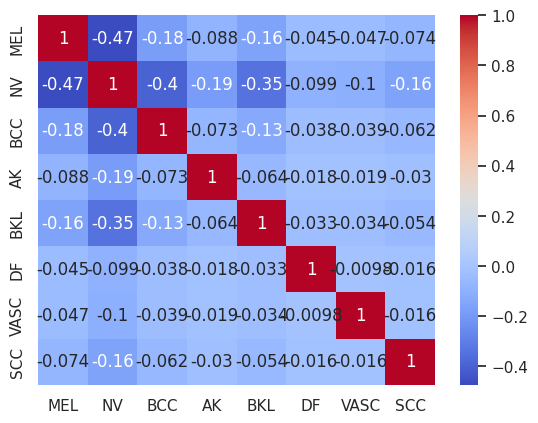

In [81]:
# Create a new dataframe with only the class labels
class_df = groundtruthdf[['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']]

# Create the correlation matrix
corr_matrix = class_df.corr()

# Plot the correlation matrix using seaborn
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

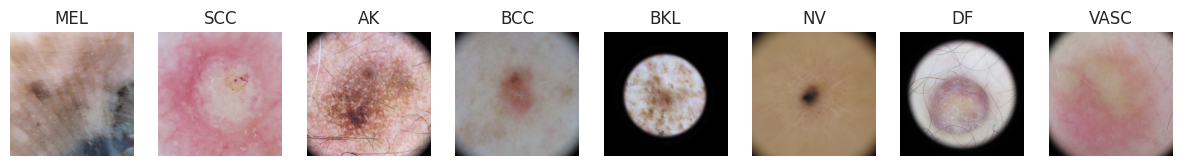

In [70]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Set the path to your image folder
image_folder = "/content/train"

# Get a list of all the classes in your image folder
class_names = os.listdir(image_folder)

# Create a figure with one row and as many columns as there are classes
fig, axs = plt.subplots(1, len(class_names), figsize=(15, 5))

# Loop through each class and display an image
for i, class_name in enumerate(class_names):
    # Get the path to an example image in the current class
    class_folder = os.path.join(image_folder, class_name)
    image_files = os.listdir(class_folder)
    image_path = os.path.join(class_folder, image_files[0])

    # Load the image using Pillow
    image = Image.open(image_path)

    # Display the image in the appropriate subplot
    axs[i].imshow(image)
    axs[i].set_title(class_name)
    axs[i].axis("off")

# Show the plot
plt.show()

In [40]:
# Calculate summary statistics
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                25331 non-null  object 
 1   age_approx           24894 non-null  float64
 2   anatom_site_general  22700 non-null  object 
 3   lesion_id            23247 non-null  object 
 4   sex                  24947 non-null  object 
 5   dx                   25331 non-null  object 
dtypes: float64(1), object(5)
memory usage: 1.2+ MB
None
         age_approx
count  24894.000000
mean      54.028481
std       18.130971
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max       85.000000


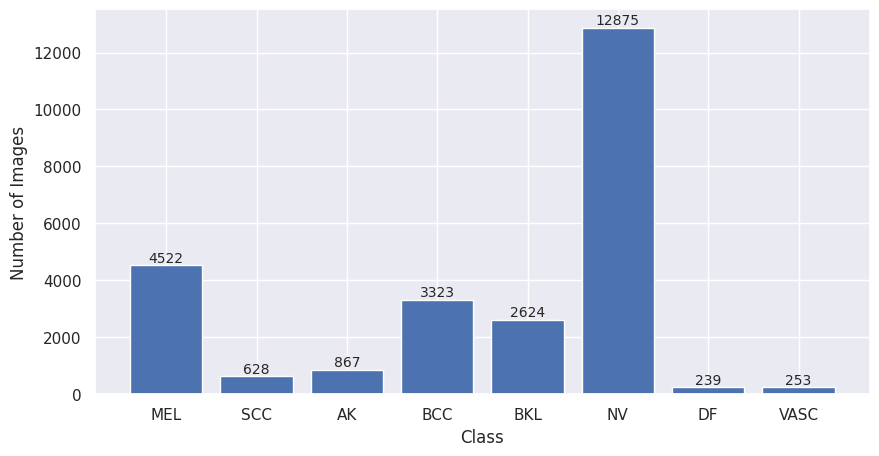

In [51]:
# Count the number of images in each class
class_counts = {}
for class_name in os.listdir(train_path):
    class_path = os.path.join(train_path, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# Plot the histogram of class frequencies with count of each class displayed on top
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(class_counts.keys(), class_counts.values())
ax.set_xlabel("Class")
ax.set_ylabel("Number of Images")

# Add counts as text on top of each bar
for i, bar in enumerate(bars):
    ax.text(bar.get_x() + bar.get_width()/2.0, bar.get_height(), class_counts[list(class_counts.keys())[i]], 
            ha='center', va='bottom', fontsize=10)

plt.show()

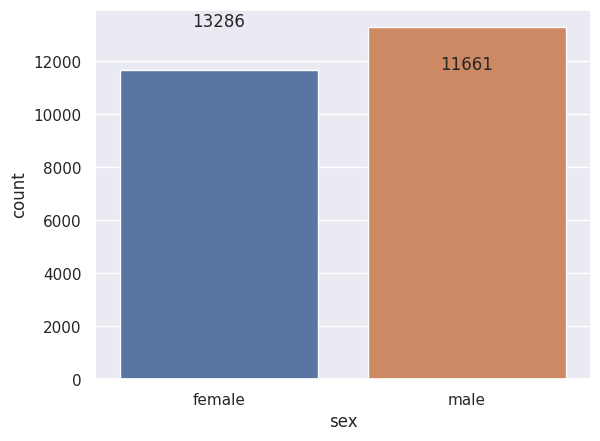

In [54]:
#this code shows the distribution between male and female
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
ax = sns.countplot(x="sex", data=data)

# Print class distribution
class_counts = data['sex'].value_counts()
for i, v in enumerate(class_counts):
    ax.text(i, v+10, str(v), ha='center', fontsize=12)

plt.show()

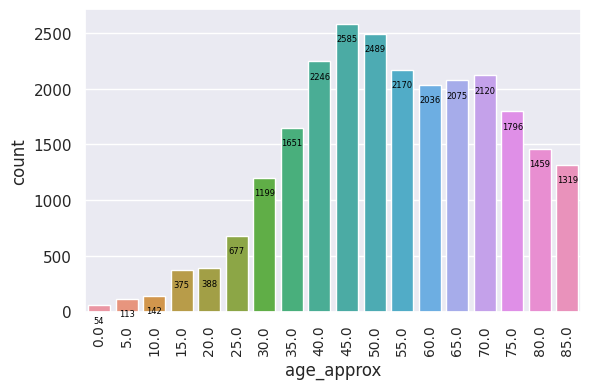

In [62]:
#this code shows the distribution of the patient ages. 
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
ax = sns.countplot(x="age_approx", data=data)

# Adjust the space between the numbers on the x-axis
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.25)

# Display count for each age_approx group
for p in ax.patches:
    ax.annotate(f'\n{int(p.get_height())}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='black', size=6)

plt.show()

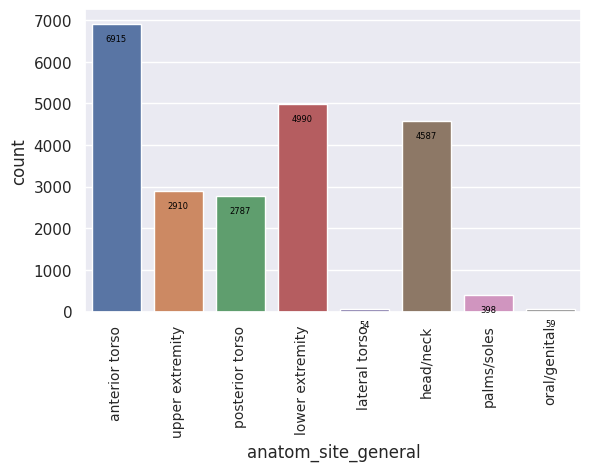

In [71]:
#this code shows the part of the body where the skin lesion is located
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
ax = sns.countplot(x="anatom_site_general", data=data)

# Adjust the space between the numbers on the x-axis
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.25)

# Display count for each age_approx group
for p in ax.patches:
    ax.annotate(f'\n{int(p.get_height())}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='black', size=6)

plt.show()